# Model performance evaluation
## Context and objectives
Since the start of this project, I had the chance to present it twice to industry experts. From both presentations I received a number of feedback points related to the performance of the system and its viability in a real-case scenario. In particular, the comments were related to the following points:
1. The dataset is heavily imbalanced (193 shooters against 1000 negatively classified individuals in the best case and 300M+ individuals in the US population)
2. Because the risk associated with a false negative and the ethics of a false positive, the precision and recall may be carefully balanced

Since then, I have also better understood different performance metrics such as the F1-score and the ROC Curve and AUC. I also want to spend more time on looking at the classification threshold.

## Methodology
In this notebook, I spend more time evaluating each of the models I have developped. I first start with the Logistic Regression which is recommended as a first model thanks to its balance of performance and interpretability.
### Preparation
For this model, the following steps are used for all iterations:
1. Import and split the data
2. Scale the data

### Hyperparameters to consider
I look at different parameters:
```python
    solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    max_iter = list(range(20,100))
    regularisations = np.linspace(.1, 2, 20)
    penalties = ['l1', 'l2', 'elsticnet']
```

### Metrics
- accuracy
- precision-recall curve
- f1 curve
- roc curve and auc

In [4]:
# Ignore all warnings
from warnings import simplefilter
simplefilter(action='ignore')

# Data and files manipulation
import numpy as np
import pandas as pd
from pathlib import Path
import pickle

# Visualisation
from matplotlib import pyplot as plt
import seaborn as sns

# Import dependencies

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# Import the models from SKLearn (Model 1 through Model 6)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Import the modules to evaluate the models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve

In [5]:
# Shooter data
shooters_df = pd.read_csv(Path('model_blackbox_shooters.csv'))

# General Population data
genpop_df = pd.read_csv(Path('model_blackbox_genpop.csv'))

# Create one table with all data
all_data = pd.concat([shooters_df, genpop_df], axis=0)

# Separate the data into labels and features
# Separate the y variable, the labels
y = all_data['Classification']

# Separate the X variable, the features
X = all_data.drop(columns='Classification')

# Get dummies
dummies_df = pd.get_dummies(X.drop(columns=['Age']))
X = pd.concat([X['Age'], dummies_df], axis=1)

# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1,stratify=y, test_size=0.2)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Prevalence
Here we quantify how balanced the dataset is.

In [6]:
print('Prevalence (Class 1)')
print(f"In train set: {100*y_train.mean():.2f}%")
print(f"In test set: {100*y_test.mean():.2f}%")

Prevalence (Class 1)
In train set: 1.89%
In test set: 1.91%


## Model preparation

### Training

In [7]:
model_1 = LogisticRegression(solver='saga', random_state=10, max_iter=100).fit(X_train_scaled, y_train)

### Predictions on test data

In [8]:
y_pred_1 = model_1.predict(X_test_scaled)
y_proba_1 = model_1.predict_proba(X_test_scaled)[:,1]

## Performance evaluation

### Confusion matrix

In [9]:
def show_confusion_matrix(matrix, title, save=False):
    fig, ax = plt.subplots()

    sns.heatmap(
        matrix,
        cmap='Blues',
        annot=True,
        fmt='g',
        square=True,
        xticklabels=['0', '1'],
        yticklabels=['0', '1']
    ).set(
        xlabel='ACTUAL',
        ylabel='PREDICTED',
        title=title
    )

    if save:
        plt.savefig(f'{title}.png')
    
    plt.show()

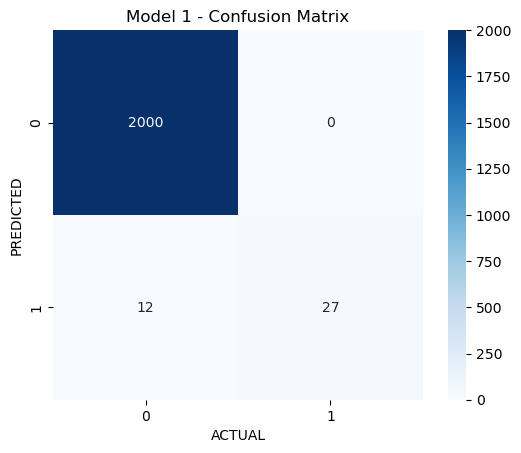

In [10]:
model_1_cm = confusion_matrix(y_test, y_pred_1)
show_confusion_matrix(model_1_cm, 'Model 1 - Confusion Matrix')

### Accuracy, recall and precision

In [11]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_1)*100:.1f}%")
print(f"Precision: {precision_score(y_test, y_pred_1)*100:.1f}%")
print(f"Recall: {recall_score(y_test, y_pred_1)*100:.1f}%")
print(f"F1 score: {f1_score(y_test, y_pred_1)*100:.1f}%")

print('\nReport:')
print(classification_report(y_test, y_pred_1))

Accuracy: 99.4%
Precision: 100.0%
Recall: 69.2%
F1 score: 81.8%

Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2000
           1       1.00      0.69      0.82        39

    accuracy                           0.99      2039
   macro avg       1.00      0.85      0.91      2039
weighted avg       0.99      0.99      0.99      2039



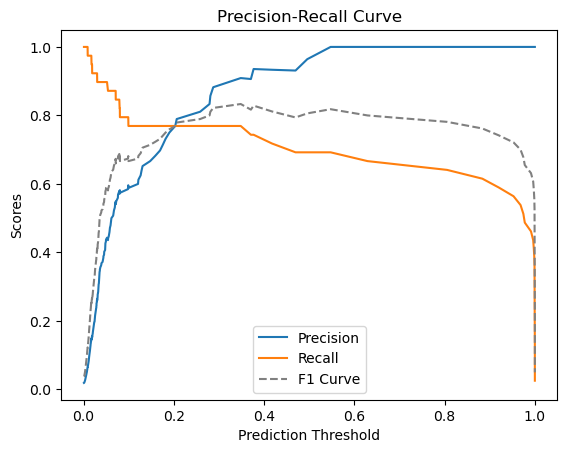

In [12]:
# Get P-R curve parameters (numpy arrays)
p_curve, r_curve, t_curve = precision_recall_curve(y_test, y_proba_1)

# Calculate F1 score
f1_scores = [f1_score(y_test, (y_proba_1 >= threshold)) for threshold in t_curve]

# Plot curve
plt.plot(t_curve, p_curve[:-1], label = 'Precision')
plt.plot(t_curve, r_curve[:-1], label = 'Recall')
plt.plot(t_curve, f1_scores, label='F1 Curve', ls='--', c='grey')
plt.xlabel('Prediction Threshold')
plt.ylabel('Scores')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()

### ROC Curve and AUC

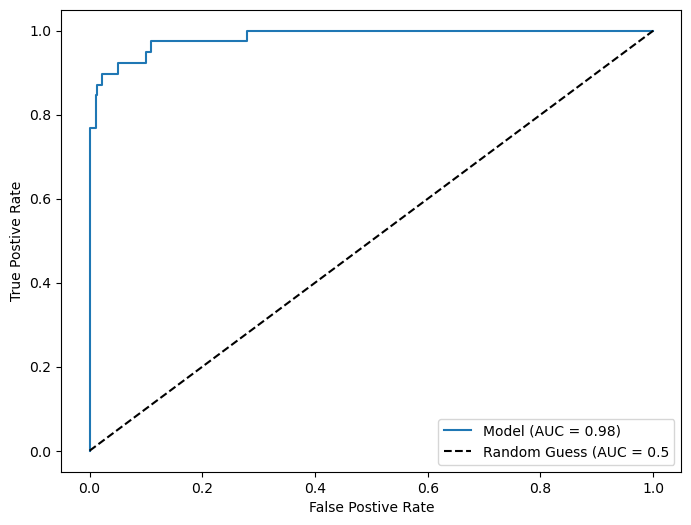

In [13]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve and the area under curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_1)
auc_score = auc(fpr, tpr)

# Plot the ROC Curve
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(fpr, tpr, label = f'Model (AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], 'k--', label = 'Random Guess (AUC = 0.5',)

# Formatting
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.legend()
plt.show()

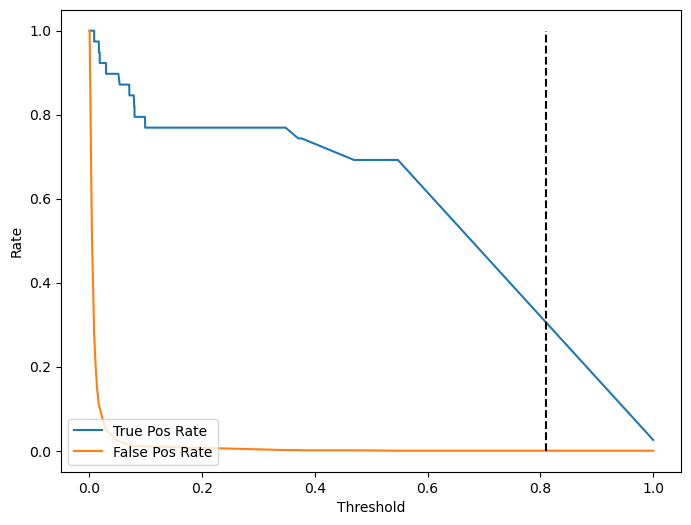

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(thresholds, tpr, label = 'True Pos Rate')
plt.plot(thresholds, fpr, label = 'False Pos Rate')
plt.vlines(0.81, 0, 1, colors='k', ls='--')
plt.legend(loc='lower left')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.show()

## Resampling methods

In [15]:
import imblearn.over_sampling as OS

In [17]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

# Create Nx as many positive samples
N = 4
ratio = {1: n_pos*N, 0: n_neg}

# Randomly oversample
ROS = OS.RandomOverSampler(
	sampling_strategy = ratio,
	random_state = 42
)

X_train_rs, y_train_rs = ROS.fit_resample(X_train, y_train)

print(f"Original Pos Class Count: {np.sum(y_train)}")
print(f"Oversample Pos Class Count: {np.sum(y_train_rs)}")

Original Pos Class Count: 154
Oversample Pos Class Count: 616
